Loaded binary matrix with shape: (48, 256)

Total notes on: 148
Note density: 0.0120



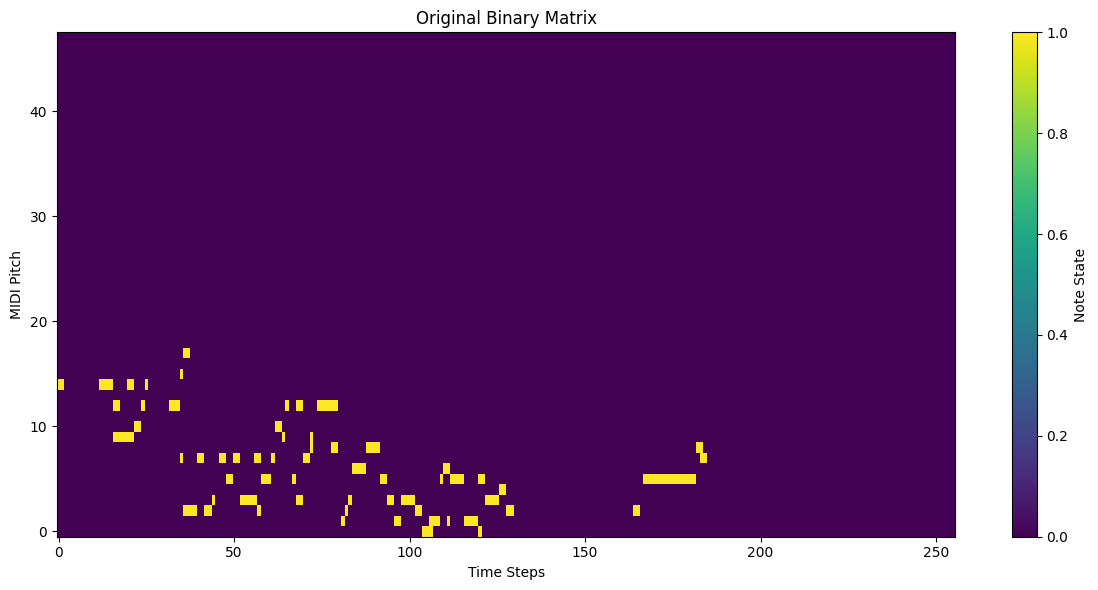

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_matrix(file_path):
    """
    Loads a binary matrix from a .npy file and processes its shape.

    Parameters:
    - file_path (str): Path to the .npy file containing the binary matrix.

    Returns:
    - binary_matrix (np.ndarray): Processed binary matrix.
    """
    binary_matrix = np.load(file_path)
    if binary_matrix.ndim == 1:
        raise ValueError("Loaded matrix is 1-dimensional. Expected a 2D matrix.")
    if binary_matrix.shape[0] == 1:
        binary_matrix = binary_matrix.squeeze()
    return binary_matrix

def calculate_note_density(binary_matrix):
    """
    Calculates the density of notes in the binary matrix.

    Parameters:
    - binary_matrix (np.ndarray): Binary matrix where 1 represents a note on and 0 represents a note off.

    Returns:
    - density (float): Proportion of notes that are on.
    """
    total_notes = np.sum(binary_matrix)
    total_possible = binary_matrix.size
    density = total_notes / total_possible
    return density

def filter_isolated_notes(matrix):
    """
    Filters out isolated ones (notes) in the matrix. A '1' is considered isolated if it is surrounded by '0's in its column.

    Parameters:
    - matrix (np.ndarray): Binary matrix to be filtered.

    Returns:
    - filtered_matrix (np.ndarray): Binary matrix with isolated ones set to zero.
    """
    filtered_matrix = matrix.copy()
    rows, cols = matrix.shape
    for i in range(rows):
        for j in range(1, cols - 1):
            if matrix[i, j] == 1 and matrix[i, j - 1] == 0 and matrix[i, j + 1] == 0:
                filtered_matrix[i, j] = 0
    return filtered_matrix

def visualize_matrix(matrix, title="Binary Matrix Visualization"):
    """
    Visualizes the binary matrix as a heatmap.

    Parameters:
    - matrix (np.ndarray): Binary matrix to visualize.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.imshow(matrix, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Note State')
    plt.ylabel('MIDI Pitch')
    plt.xlabel('Time Steps')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def process_binary_matrix(file_path, denoise=False):
    """
    Loads, processes, and optionally denoises a binary matrix. Also calculates and prints note density.

    Parameters:
    - file_path (str): Path to the .npy file containing the binary matrix.
    - denoise (bool): If True, filters out isolated notes.

    Returns:
    - binary_matrix (np.ndarray): Original binary matrix.
    - processed_matrix (np.ndarray): Filtered binary matrix if denoise=True, else the original matrix.
    """
    # Load and process the binary matrix
    binary_matrix = load_and_process_matrix(file_path)
    print(f"Loaded binary matrix with shape: {binary_matrix.shape}\n")

    # Calculate and display note density
    density = calculate_note_density(binary_matrix)
    total_notes = np.sum(binary_matrix)
    print(f"Total notes on: {total_notes}")
    print(f"Note density: {density:.4f}\n")

    # Visualize the original matrix
    visualize_matrix(binary_matrix, title="Original Binary Matrix")

    if denoise:
        # Filter isolated notes
        filtered_matrix = filter_isolated_notes(binary_matrix)
        filtered_total_notes = np.sum(filtered_matrix)
        filtered_density = calculate_note_density(filtered_matrix)
        print(f"After denoising:")
        print(f"Total notes on: {filtered_total_notes}")
        print(f"Note density: {filtered_density:.4f}\n")

        # Visualize the filtered matrix
        visualize_matrix(filtered_matrix, title="Filtered Binary Matrix")

        return binary_matrix, filtered_matrix
    else:
        # Return original matrix twice for consistency
        return binary_matrix, binary_matrix


# Path to your binary matrix file
file_path = 'binary_image_4.npy'
    
# Process the matrix without denoising
original_matrix, processed_matrix = process_binary_matrix(file_path, denoise=False)
    
# If you want to apply denoising, set denoise=True
# original_matrix, processed_matrix = process_binary_matrix(file_path, denoise=True)

In [4]:
import numpy as np
import mido
from mido import MidiFile, MidiTrack, Message, second2tick
import ipywidgets as widgets
from ipywidgets import Output
from IPython.display import display, clear_output
import pygame
import time

binary_matrix = original_matrix

def generate_midi(
    midi_matrix, 
    output_filename='output_test.mid', 
    smallest_duration_ms=400, 
    lowest_midi_pitch=51,
    tempo=500000,  # Default tempo (microseconds per beat)
    velocity=64     # Default velocity for note_on and note_off
):
    """
    Generates a MIDI file from a binary matrix.
    """
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo))
    ticks_per_smallest_duration = second2tick(
        smallest_duration_ms / 1000, 
        mid.ticks_per_beat, 
        tempo
    )
    note_states = np.zeros(midi_matrix.shape[0], dtype=int)
    time_since_last_event = 0

    for col_index in range(midi_matrix.shape[1]):
        for row_index, note_state in enumerate(midi_matrix[:, col_index]):
            note = lowest_midi_pitch + row_index
            if note_state != note_states[row_index]:
                note_states[row_index] = note_state
                msg_type = 'note_on' if note_state == 1 else 'note_off'
                track.append(Message(
                    msg_type, 
                    note=note, 
                    velocity=velocity, 
                    time=int(time_since_last_event)
                ))
                time_since_last_event = 0
        time_since_last_event += ticks_per_smallest_duration

    for row_index, state in enumerate(note_states):
        if state == 1:
            note = lowest_midi_pitch + row_index
            track.append(Message('note_off', note=note, velocity=velocity, time=int(time_since_last_event)))

    mid.save(output_filename)
    print(f'MIDI file saved successfully: {output_filename}')

generate_midi(
    midi_matrix=binary_matrix, 
    output_filename='output_test1.mid', 
    smallest_duration_ms=150, 
    lowest_midi_pitch=51
)

pygame.init()
pygame.mixer.init()

is_playing = False
midi_file_location = "output_test1.mid"

midi_player = Output()

play_button = widgets.Button(description='Play MIDI', button_style='success')
stop_button = widgets.Button(description='Stop MIDI', button_style='danger')
stop_button.disabled = True

def play_midi(b):
    global is_playing
    with midi_player:
        clear_output(wait=True)
        try:
            pygame.mixer.music.load(midi_file_location)
            pygame.mixer.music.play()
            is_playing = True
            play_button.disabled = True
            stop_button.disabled = False
            print(f'Playing {midi_file_location}...')
        except Exception as e:
            print(f'Error playing MIDI file: {e}')

def stop_midi(b):
    global is_playing
    if is_playing:
        pygame.mixer.music.stop()
        is_playing = False
        play_button.disabled = False
        stop_button.disabled = True
        print('Playback stopped.')

play_button.on_click(play_midi)
stop_button.on_click(stop_midi)

button_box = widgets.HBox([play_button, stop_button])
display(button_box)
display(midi_player)


MIDI file saved successfully: output_test1.mid


Output()